#     Bayes Project: A nonconjugate, nonlinear model.
#     (Dugongs)

### Authors: 
---
* Abdellah Koutit
* Karim IDRISSI
* Elias Mourdi
* Najib Selamnia

---

### Importation des bibliothèques 

In [24]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, truncnorm, uniform
import statsmodels.api as sm

### Données 

In [25]:
X = np.array([1, 1.5, 1.5, 1.5, 2.5, 4, 5, 5, 7, 8, 8.5, 9, 9.5, 9.5, 10,
              12, 12, 13, 13, 14.5, 15.5, 15.5, 16.5, 17, 22.5, 29, 31.5])

Y = np.array([1.8, 1.85, 1.87, 1.77, 2.02, 2.27, 2.15, 2.26, 2.47, 2.19,
              2.26, 2.4, 2.39, 2.41, 2.5, 2.32, 2.32, 2.43, 2.47, 2.56, 2.65,
              2.47, 2.64, 2.56, 2.7, 2.72, 2.57])

In [26]:
donnees = pd.DataFrame({"X": X, "Y": Y})
donnees.reset_index(drop=True, inplace=True)
donnees

,X,Y
0,1.0,1.80
1,1.5,1.85
2,1.5,1.87
3,1.5,1.77
4,2.5,2.02
5,4.0,2.27
6,5.0,2.15
7,5.0,2.26
8,7.0,2.47
9,8.0,2.19


In [27]:
lissage = sm.nonparametric.lowess
points_lisses = lissage(donnees["Y"], donnees["X"], frac=0.4)

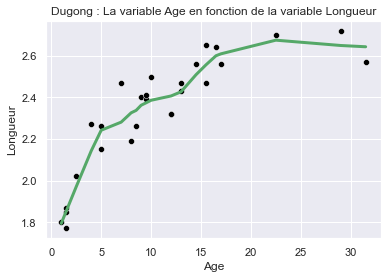

In [28]:
# Visualisation 
sns.scatterplot(x="X", y="Y", data=donnees, color='black')
plt.plot(points_lisses[:, 0], points_lisses[:, 1], 'g-', lw=3)
plt.title("Dugong : La variable Age en fonction de la variable Longueur")
plt.xlabel("Age")
plt.ylabel("Longueur")
plt.show()

## Fonctions Utilitaires pour le code

In [29]:
def logit(x):
    return np.log(x / (1 - x))

def inv_logit(x):
    return 1 / (1 + np.exp(-x))

In [30]:
def gibbs_sampling(age, Y, nchain=10**4, propo_sd=np.array([0.02, 0.8, 4, 0.25])):
    initialisation = np.array([1, 1, 1, 0.9])
    chain = np.empty((nchain + 1, 4))
    chain[0, :] = initialisation
    ecart_type = 1000

    for i in range(nchain):
        etat_actuel = chain[i, :]

        # Mise à jour de alpha
        propo = etat_actuel.copy()
        propo[0] = np.random.lognormal(np.log(etat_actuel[0]), propo_sd[0])
        kernel_ratio = propo[0] / etat_actuel[0] 

        top = np.sum(norm.logpdf(Y, propo[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            norm.logpdf(propo[0], 0, ecart_type)
        bottom = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            norm.logpdf(etat_actuel[0], 0, ecart_type)

        proba_accept = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < proba_accept:
            etat_actuel = propo.copy()

        # Mise à jour de beta
        propo = etat_actuel.copy()
        propo[1] = np.random.lognormal(np.log(etat_actuel[1]), propo_sd[1])
        kernel_ratio = propo[1] / etat_actuel[1]

        top = np.sum(norm.logpdf(Y, etat_actuel[0] - propo[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            norm.logpdf(propo[1], 0, ecart_type)
        bottom = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            norm.logpdf(etat_actuel[1], 0, ecart_type)

        proba_accept = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < proba_accept:
            etat_actuel = propo.copy()

        # Mise à jour de tau
        propo = etat_actuel.copy()
        propo[2] = np.random.lognormal(np.log(etat_actuel[2]), propo_sd[2])

        kernel_ratio = propo[2] / etat_actuel[2]

        top = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(propo[2]))) + \
            gamma.logpdf(propo[2], a=0.001, scale=1/0.001)
        bottom = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            gamma.logpdf(etat_actuel[2], a=0.001, scale=1/0.001)

        proba_accept = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < proba_accept:
            etat_actuel = propo.copy()
        # Mise à jour de gamma
        propo = etat_actuel.copy()
        propo[3] = np.random.lognormal(np.log(etat_actuel[3]), propo_sd[3])

        kernel_ratio = propo[3] / etat_actuel[3]
        top = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * propo[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            uniform.logpdf(propo[3], 0.5, 0.5)
        bottom = np.sum(norm.logpdf(Y, etat_actuel[0] - etat_actuel[1] * etat_actuel[3] ** age, 1 / np.sqrt(etat_actuel[2]))) + \
            uniform.logpdf(etat_actuel[3], 0.5, 0.5)

        proba_accept = np.exp(top - bottom) * kernel_ratio

        if np.random.uniform() < proba_accept and propo[3] < 1:
            etat_actuel = propo.copy()

        # Sauvegarde du nouvel état
        chain[i + 1, :] = etat_actuel

    return chain

## Visualization of the parameters $\alpha , \tau, \gamma , \beta $ : 


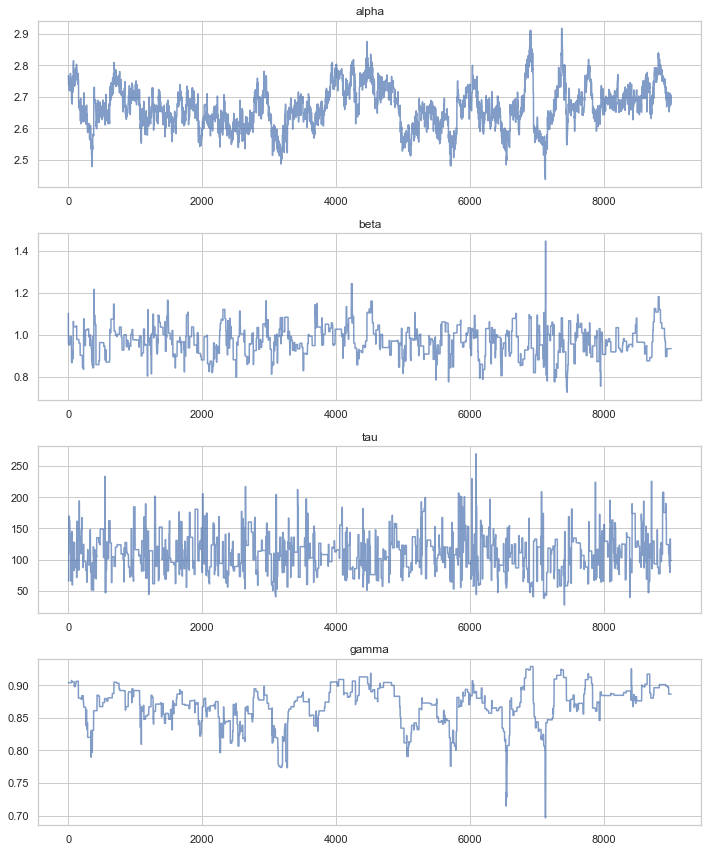

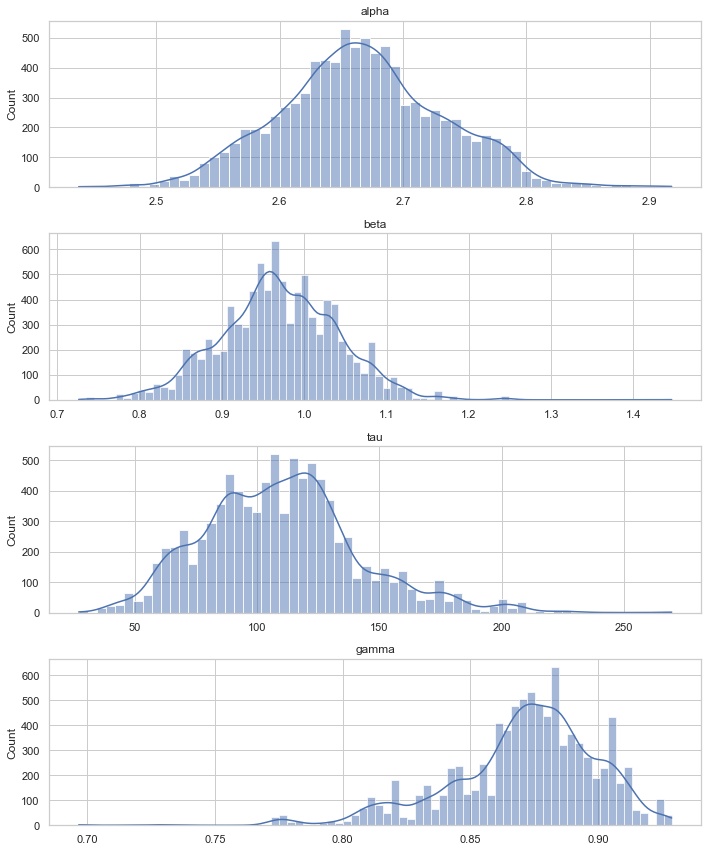

In [31]:
nchain = 10000
chain = gibbs_sampling(X, Y, nchain)

# Remove burning period
burn_in = 1000
chain = chain[burn_in:]

# Set the style for the plots
sns.set(style="whitegrid")

param_names = ['alpha', 'beta', 'tau', 'gamma']

def plot_trace(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        ax.plot(chains[:, idx], alpha=0.7)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

def plot_histograms(chains, param_names):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        sns.histplot(chains[:, idx], kde=True, ax=ax)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

plot_trace(chain, param_names)
plot_histograms(chain, param_names)


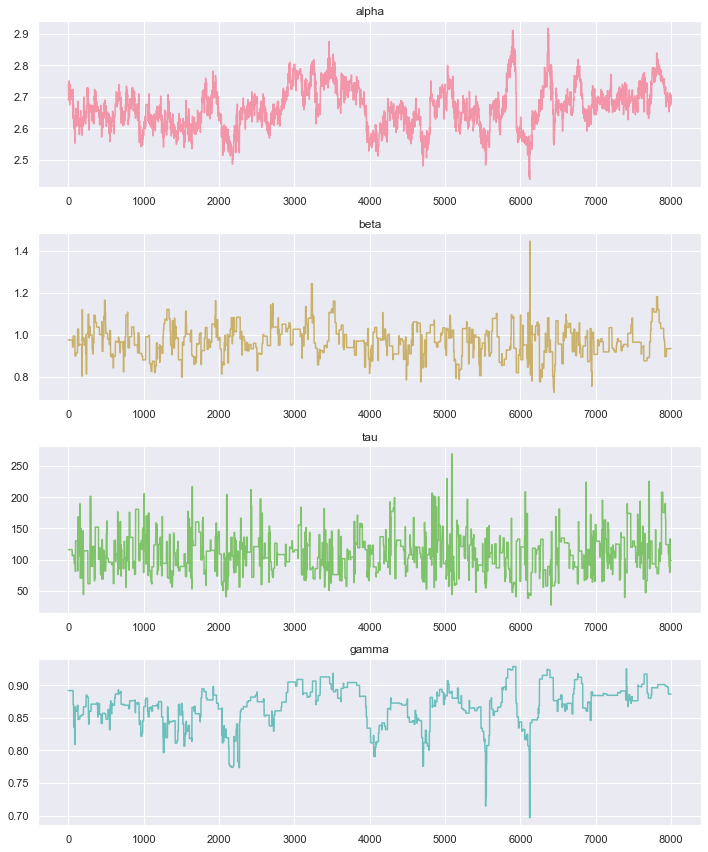

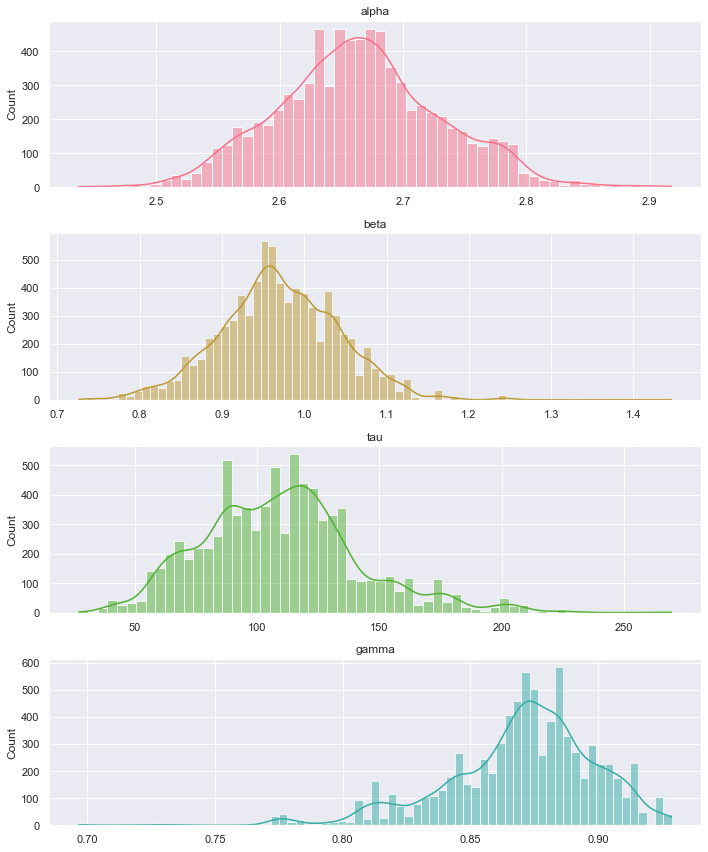

In [32]:
# Set the style for the plots and define custom color palette
sns.set(style="darkgrid")
custom_palette = sns.color_palette("husl")

# Trace plots
def plot_trace(chains, param_names, burn_in=0):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        ax.plot(chains[burn_in:, idx], color=custom_palette[idx], alpha=0.7)
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

# Histograms
def plot_histograms(chains, param_names, burn_in=0):
    n_params = len(param_names)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 3 * n_params))

    for idx, ax in enumerate(axes):
        sns.histplot(chains[burn_in:, idx], kde=True, ax=ax, color=custom_palette[idx])
        ax.set_title(param_names[idx])

    plt.tight_layout()
    plt.show()

# Summary statistics
def summarize_chains(chains, param_names, burn_in):
    summary_df = pd.DataFrame(chains[burn_in:], columns=param_names).describe().transpose()
    return summary_df



# Plot trace plots and histograms for alpha, beta1, beta2, sigma2
param_names = ['alpha', 'beta', 'tau', 'gamma']
plot_trace(chain, param_names, burn_in)
plot_histograms(chain, param_names, burn_in)





## Analyse de la croissance des dugongs : Modélisation et prévisions basées sur les données observées

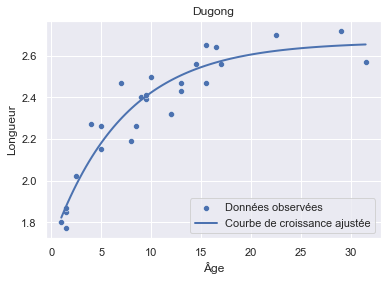

Longueur prédite pour un dugong de 20 ans : 2.61


In [33]:
# Courbe de croissance ajustée
def courbe_de_croissance_ajustee(age, alpha, beta, gamma):
    return alpha - beta * gamma ** age

# Valeurs moyennes des paramètres
moyenne_alpha = np.mean(chain[:, 0])
moyenne_beta = np.mean(chain[:, 1])
moyenne_gamma = np.mean(chain[:, 3])

# Tracer les données observées et la courbe de croissance ajustée
sns.scatterplot(x="X", y="Y", data=donnees, label="Données observées")
plage_age = np.linspace(X.min(), X.max(), 100)
plt.plot(plage_age, courbe_de_croissance_ajustee(plage_age, moyenne_alpha, moyenne_beta, moyenne_gamma), 'b-', lw=2, label="Courbe de croissance ajustée")
plt.title("Dugong")
plt.xlabel("Âge")
plt.ylabel("Longueur")
plt.legend()
plt.show()

# Prédire la longueur d'un nouveau dugong avec un âge donné
nouvel_age = 20
longueur_predite = courbe_de_croissance_ajustee(nouvel_age, moyenne_alpha, moyenne_beta, moyenne_gamma)
print(f"Longueur prédite pour un dugong de {nouvel_age} ans : {longueur_predite:.2f}")


Le graphique affiche la relation entre l'âge et la longueur des dugongs, avec les points de données observés et une courbe de croissance ajustée. La courbe de croissance ajustée, tracée en rouge, est basée sur les valeurs moyennes des paramètres estimés à partir de l'algorithme de Gibbs.

Le graphique illustre que la courbe de croissance ajustée suit de près les points de données observés, démontrant que le modèle est approprié pour analyser la croissance des dugongs. Il montre également la nature non linéaire de la relation entre l'âge et la longueur, avec le taux de croissance ralentissant à mesure que les dugongs vieillissent.

De plus, la longueur prédite pour un dugong de 20 ans est affichée comme étant de 2.61, fournissant une estimation de la longueur du dugong basée sur la courbe de croissance ajustée.
